In [21]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import tensorflow as tf
from math import sqrt

In [2]:
def define_discriminator(in_shape=(28,28,1),n_classes=10):
    init=RandomNormal(stddev=0.02)
    
    in_image=Input(shape=in_shape)
    
    fe=Conv2D(32,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)

    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)

    fe = Flatten()(fe)

    out1 = Dense(1, activation='sigmoid')(fe)

    out2 = Dense(n_classes, activation='softmax')(fe)

    model = Model(in_image, [out1, out2])

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

In [3]:
define_discriminator().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

c:\Users\prath\anaconda3\envs\py39\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
c:\Users\prath\anaconda3\envs\py39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [4]:
def define_generator(latent_dim,n_classes=10):
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

In [5]:
define_generator(100).summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

In [6]:
def define_gan(g_model,d_model):
    for layer in d_model.layers:
        if not isinstance(layer,BatchNormalization):
            layer.trainable=False
        gan_output=d_model(g_model.output)
        model=Model(g_model.input,gan_output)
        model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=Adam(lr=0.0002,beta_1=0.5))
        return model

In [7]:
def load_real_samples():
 # load dataset
 (trainX, trainy), (_, _) = load_data()
 # expand to 3d, e.g. add channels
 X = np.expand_dims(trainX, axis=-1)
 # convert from ints to floats
 X = X.astype('float32')
 # scale from [0,255] to [-1,1]
 X = (X - 127.5) / 127.5
 print(X.shape, trainy.shape)
 return [X, trainy]

In [8]:
def generate_real_samples(dataset, n_samples):
 # split into images and labels
 images, labels = dataset
 # choose random instances
 ix = np.random.randint(0, images.shape[0], n_samples)
 # select images and labels
 X, labels = images[ix], labels[ix]
 # generate class labels
 y = np.ones((n_samples, 1))
 return [X, labels], y

In [9]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
 # generate points in the latent space
 x_input = np.random.randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 z_input = x_input.reshape(n_samples, latent_dim)
 # generate labels
 labels = np.random.randint(0, n_classes, n_samples)
 return [z_input, labels]

In [10]:
def generate_fake_samples(generator, latent_dim, n_samples):
 # generate points in latent space
 z_input, labels_input = generate_latent_points(latent_dim, n_samples)
 # predict outputs
 images = generator.predict([z_input, labels_input],verbose=0)
 # create class labels
 y = np.zeros((n_samples, 1))
 return [images, labels_input], y

In [11]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
 # prepare fake examples
 [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
 # scale from [-1,1] to [0,1]
 X = (X + 1) / 2.0
 # plot images
 for i in range(100):
 # define subplot
     plt.subplot(10, 10, 1 + i)
     # turn off axis
     plt.axis('off')
     # plot raw pixel data
     plt.imshow(X[i, :, :, 0], cmap='gray_r')
     # save plot to file
 filename1 = 'generated_plot_%04d.png' % (step+1)
 plt.savefig(filename1)
 plt.close()
 # save the generator model
 filename2 = 'model_%04d.h5' % (step+1)
 g_model.save(filename2)
 print('>Saved: %s and %s' % (filename1, filename2))

In [12]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
 tf.get_logger().setLevel('ERROR')
 # calculate the number of batches per training epoch
 bat_per_epo = int(dataset[0].shape[0] / n_batch)
 # calculate the number of training iterations
 n_steps = bat_per_epo * n_epochs
 # calculate the size of half a batch of samples
 half_batch = int(n_batch / 2)
 # manually enumerate epochs
 for i in range(n_steps):
 # get randomly selected 'real' samples
     [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
     # update discriminator model weights
     _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
     # generate 'fake' examples
     [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
     # update discriminator model weights
     _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
     # prepare points in latent space as input for the generator
     [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
     # create inverted labels for the fake samples
     y_gan = np.ones((n_batch, 1))
     # update the generator via the discriminator's error
     _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
    
     if(i%1000==0):
            print(i)
     
     # evaluate the model performance every 'epoch'
     if (i+1) % (bat_per_epo * 10) == 0:
         summarize_performance(i, g_model, latent_dim)

In [13]:
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

(60000, 28, 28, 1) (60000,)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
>Saved: generated_plot_9370.png and model_9370.h5
10000
11000
12000
13000
14000
15000
16000
17000
18000
>Saved: generated_plot_18740.png and model_18740.h5
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
>Saved: generated_plot_28110.png and model_28110.h5
29000
30000
31000
32000
33000
34000
35000
36000
37000
>Saved: generated_plot_37480.png and model_37480.h5
38000
39000
40000
41000
42000
43000
44000
45000
46000
>Saved: generated_plot_46850.png and model_46850.h5
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
>Saved: generated_plot_56220.png and model_56220.h5
57000
58000
59000
60000
61000
62000
63000
64000
65000
>Saved: generated_plot_65590.png and model_65590.h5
66000
67000
68000
69000
70000
71000
72000
73000
74000
>Saved: generated_plot_74960.png and model_74960.h5
75000


KeyboardInterrupt: 

4/4 [==============================] - 1s 120ms/step


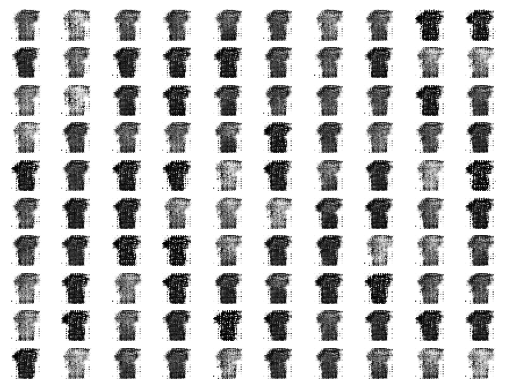

In [28]:
def save_plot(examples, n_examples):
    n_rows = int(sqrt(n_examples))
    n_cols = int(sqrt(n_examples))
    # plot images
    for i in range(n_examples):
    # define subplot
        plt.subplot(n_rows, n_cols, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

model=load_model('model_74960.h5')
latent_dim = 100
n_examples = 100 # must be a square
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_examples)